In [ ]:
#import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
#additional packages
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, auc, roc_curve
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [ ]:
#need more packages:
from sklearn.model_selection import GridSearchCV



In [ ]:
#load the dataset
from google.colab import drive
drive.mount('/content/drive')
X_test = pd.read_csv('/content/drive/MyDrive/BTAI (1)/tweetsum_test.csv')
X_train = pd.read_csv('/content/drive/MyDrive/BTAI (1)/tweetsum_train.csv')
X_val = pd.read_csv('/content/drive/MyDrive/BTAI (1)/tweetsum_val.csv')

Mounted at /content/drive


In [ ]:

# Function to redirect data to the cleaned data
def clean(test,train,val):
  # Col for Word Count
  train['word_count']=train['sentence'].apply(lambda x:len(x.split()))
  test['word_count']=test['sentence'].apply(lambda x:len(x.split()))
  val['word_count']=val['sentence'].apply(lambda x:len(x.split()))

  #adding a new column to X_train "is_question" that flags true for question senteces and false for non-question sentences
  question_words = ["who", "what", "when", "where", "why", "how", "if"]
  train['is_question'] = (train['sentence'].str.endswith('?') | train['sentence'].str.lower().str.contains(fr'\b(?:{"|".join(question_words)})\b'))
  test['is_question'] = (train['sentence'].str.endswith('?') | train['sentence'].str.lower().str.contains(fr'\b(?:{"|".join(question_words)})\b'))
  val['is_question'] = (train['sentence'].str.endswith('?') | train['sentence'].str.lower().str.contains(fr'\b(?:{"|".join(question_words)})\b'))

  # # Drop sender, annot_id, dialog_id, and Unnamed: 0
  # train.drop(['sender', 'annot_id', 'dialog_id', 'Unnamed: 0'], axis = 1, inplace = True)
  # test.drop(['sender', 'annot_id', 'dialog_id', 'Unnamed: 0'], axis = 1, inplace = True)
  # val.drop(['sender', 'annot_id', 'dialog_id', 'Unnamed: 0'], axis = 1, inplace = True)

  return test,train,val

X_train, X_test, X_val = clean(X_train, X_test, X_val)

In [ ]:
# @Menna- this function can be copied for u to use! (from Hanna's TFIDF model)

#function that uses TFIDF to transform the text data of the sentences and returns the new dataframes
def TFIDF(X_test, X_train, X_val):
  # Create a TfidfVectorizer object and save it to the variable 'tfidf_vectorizer'
  # Create a TfidfVectorizer object
  tfidf_vectorizer = TfidfVectorizer(min_df=100)

  # Fit the vectorizer to X_train
  tfidf_vectorizer.fit(X_train['sentence'])

  #print the first 50 items in vocabulary
  # print("Vocabulary size {0}: ".format(len(tfidf_vectorizer.vocabulary_)))
  # print(str(list(tfidf_vectorizer.vocabulary_.items())[0:50])+'\n')

  # Using the fitted vectorizer, transform both the train, test and validation data using the fitted vectorizer
  X_train_tfidf = tfidf_vectorizer.transform(X_train['sentence'])
  X_test_tfidf = tfidf_vectorizer.transform(X_test['sentence'])
  X_val_tfidf = tfidf_vectorizer.transform(X_val['sentence'])

  # Create DataFrames for the TF-IDF vectors
  X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
  X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
  X_val_tfidf_df = pd.DataFrame(X_val_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

  # Concatenate the TF-IDF DataFrames with original
  X_train_with_tfidf = pd.concat([X_train, X_train_tfidf_df], axis=1)
  X_test_with_tfidf = pd.concat([X_test, X_test_tfidf_df], axis=1)
  X_val_with_tfidf = pd.concat([X_val, X_val_tfidf_df], axis=1)

  #drop the sentence feature- we have the vectorized one now
  X_train_with_tfidf = X_train_with_tfidf.drop("sentence", axis='columns')
  X_test_with_tfidf = X_test_with_tfidf.drop("sentence", axis='columns')
  X_val_with_tfidf = X_val_with_tfidf.drop("sentence", axis='columns')

  return X_train_with_tfidf, X_test_with_tfidf, X_val_with_tfidf

#you can now use the dataframes with the tfidf features
X_train, X_test, X_val = TFIDF(X_test, X_train, X_val)

In [ ]:
X_train.head()
X_test.head()
X_val.head()

,Unnamed: 0,dialog_id,annot_id,sender,is_salient,word_count,is_question,10,11,15,...,would,wouldn,wrong,xbox,xboxsupport,yes,yesterday,yet,you,your
0,0,caae83a2ed59e4959d814ea567980226,0,customer,True,15,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,caae83a2ed59e4959d814ea567980226,1,customer,True,15,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,caae83a2ed59e4959d814ea567980226,2,customer,True,15,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,caae83a2ed59e4959d814ea567980226,0,customer,False,2,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,caae83a2ed59e4959d814ea567980226,1,customer,False,2,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#assigning features and labels
y = X_train['is_salient'] #label

feature_list=list(X_train.select_dtypes(include = ['float64', 'int64']).columns)
X = X_train[feature_list]


In [ ]:
# Scoring Function to be used when needed
def score(X_train, y_train, model):
  scoring_functions = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro'), #might not be useful-check into this
    'recall': make_scorer(recall_score, average='macro'),
    'f1_score': make_scorer(f1_score, average='macro'),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)  # works after adding multi_class, in this scenario a continous variable is being used as the label so  multiple classes are being made
  }
  for score_name, scoring_function in scoring_functions.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring=scoring_function, error_score='raise')
    mean_score = np.mean(scores)
    # print(f'{score_name.capitalize()} Score: {mean_score:.4f}')
    results += (f'{score_name.capitalize()} Score: {mean_score:.4f}')
  return results
  print(results)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

In [ ]:
print(X_train.shape)
print(y_train.shape)

(41186, 555)
(41186,)


In [ ]:
# USING VALIDATION DATA
#Creating RF model with n = 20
print('Begin Random Forest Implementation with n = 20')
rf_20_model = RandomForestClassifier(criterion='entropy', n_estimators=20)
rf_20_model.fit(X_train, y_train)
rf_20_predictions = rf_20_model.predict(X_val)

# Creating RF model with n = 100
print('Begin Random Forest Implementation with n = 100')
rf_100_model = RandomForestClassifier(criterion='entropy', n_estimators=100)
rf_100_model.fit(X_train, y_train)
rf_100_predictions = rf_100_model.predict(X_val)

print('End')


Begin Random Forest Implementation with n = 20
Begin Random Forest Implementation with n = 100
End


In [ ]:
#accuracy score
accuracy_20 = accuracy_score(y_val, rf_20_predictions)
accuracy_100 = accuracy_score(y_val, rf_100_predictions)
print("Accuracy (n=20):", accuracy_20)
print("Accuracy (n=100):", accuracy_100)

Accuracy (n=20): 0.8253690753690753
Accuracy (n=100): 0.824980574980575


In [ ]:
precision_20  = precision_score(y_val, rf_20_predictions)
precision_100  = precision_score(y_val, rf_100_predictions)
print("Precision (n=20):", precision_20)
print("Precision (n=100):", precision_100)


Precision (n=20): 0.5709677419354838
Precision (n=100): 0.5664621676891616


In [ ]:
recall_20  = recall_score(y_val, rf_20_predictions)
recall_100  = recall_score(y_val, rf_100_predictions)
print("Recall (n=20):", recall_20)
print("Recall (n=100):", recall_100)

Recall (n=20): 0.5150339476236664
Recall (n=100): 0.5373423860329777


In [ ]:
f1_20 = f1_score(y_val, rf_20_predictions)
f1_100 = f1_score(y_val, rf_100_predictions)
print("F1 Score (n=20):", f1_20)
print("F1 Score (n=100):", f1_100)


F1 Score (n=20): 0.5415604283528812
F1 Score (n=100): 0.5515181682429069


In [ ]:
auc_roc_20 = roc_auc_score(y_val, rf_20_predictions)
auc_roc_100 = roc_auc_score(y_val, rf_100_predictions)

print("AUC/ROC Score (n=20):", auc_roc_20)
print("AUC/ROC Score (n=100):", auc_roc_100)



AUC/ROC Score (n=20): 0.7090593590437981
AUC/ROC Score (n=100): 0.717177386846948


In [ ]:
print('Computing ROC Curve...')

#Use roc_curve to record fpr and tpr for rf_20_model
fpr_20, tpr_20, thresholds_20 = roc_curve(y_val, rf_20_predictions)
#Use roc_curve to record fpr and tpr for rf_100_model
fpr_100, tpr_100, thresholds_100 = roc_curve(y_val, rf_100_predictions)

print('End')

Computing ROC Curve...
End


Plotting ROC Curve...


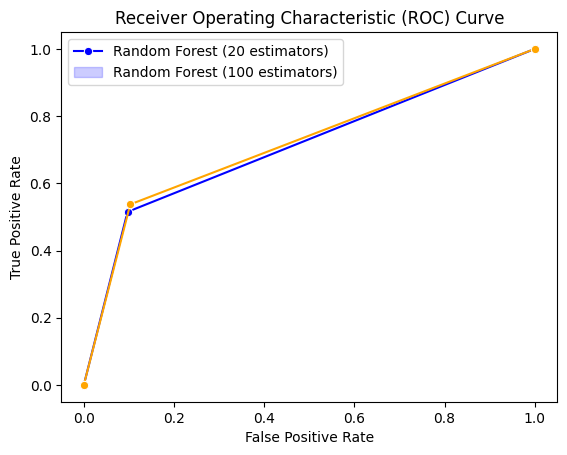

In [ ]:
print('Plotting ROC Curve...')

plt.figure()
sns.lineplot(x=fpr_20, y=tpr_20, color='blue', marker='o')
sns.lineplot(x=fpr_100, y=tpr_100, color='orange', marker='o')

plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Keep the legend labels the same but differentiate colors
plt.legend(['Random Forest (20 estimators)', 'Random Forest (100 estimators)'])

plt.show()

In [ ]:
#AUC for rf_20_model
auc_20 = auc(fpr_20, tpr_20)
print("AUC of the RF model with 20 estimators is {:.3f}".format(auc_20))

#AUC for rf_100_model
auc_100 = auc(fpr_100, tpr_100)
print("AUC of the RF model with 100 estimators is {:.3f}".format(auc_100))

AUC of the RF model with 20 estimators is 0.709
AUC of the RF model with 100 estimators is 0.717


In [ ]:
# USING TEST DATA
#Creating RF model with n = 20
print('Begin Random Forest Implementation with n = 20')
rf_20_model = RandomForestClassifier(criterion='entropy', n_estimators=20)
rf_20_model.fit(X_train, y_train)
rf_20_predictions = rf_20_model.predict(X_test)

# Creating RF model with n = 100
print('Begin Random Forest Implementation with n = 100')
rf_100_model = RandomForestClassifier(criterion='entropy', n_estimators=100)
rf_100_model.fit(X_train, y_train)
rf_100_predictions = rf_100_model.predict(X_test)

print('End')

Begin Random Forest Implementation with n = 20
Begin Random Forest Implementation with n = 100
End


In [ ]:
#accuracy score
accuracy_20 = accuracy_score(y_test, rf_20_predictions)
accuracy_100 = accuracy_score(y_test, rf_100_predictions)
print("Accuracy (n=20):", accuracy_20)
print("Accuracy (n=100):", accuracy_100)

Accuracy (n=20): 0.8275393280248592
Accuracy (n=100): 0.8234608661876093


In [ ]:
precision_20  = precision_score(y_test, rf_20_predictions)
precision_100  = precision_score(y_test, rf_100_predictions)
print("Precision (n=20):", precision_20)
print("Precision (n=100):", precision_100)

Precision (n=20): 0.576307363927428
Precision (n=100): 0.5626283367556468


In [ ]:
recall_20  = recall_score(y_test, rf_20_predictions)
recall_100  = recall_score(y_test, rf_100_predictions)
print("Recall (n=20):", recall_20)
print("Recall (n=100):", recall_100)

Recall (n=20): 0.5237633365664404
Recall (n=100): 0.5315227934044617


In [ ]:
f1_20 = f1_score(y_test, rf_20_predictions)
f1_100 = f1_score(y_test, rf_100_predictions)
print("F1 Score (n=20):", f1_20)
print("F1 Score (n=100):", f1_100)

F1 Score (n=20): 0.5487804878048781
F1 Score (n=100): 0.5466334164588529


In [ ]:
auc_roc_20 = roc_auc_score(y_test, rf_20_predictions)
auc_roc_100 = roc_auc_score(y_test, rf_100_predictions)

print("AUC/ROC Score (n=20):", auc_roc_20)
print("AUC/ROC Score (n=100):", auc_roc_100)

AUC/ROC Score (n=20): 0.713678657112749
AUC/ROC Score (n=100): 0.7140372587711964


In [ ]:
print('Computing ROC Curve...')

#Use roc_curve to record fpr and tpr for rf_20_model
fpr_20, tpr_20, thresholds_20 = roc_curve(y_test, rf_20_predictions)
#Use roc_curve to record fpr and tpr for rf_100_model
fpr_100, tpr_100, thresholds_100 = roc_curve(y_test, rf_100_predictions)

print('End')

Computing ROC Curve...
End


Plotting ROC Curve...


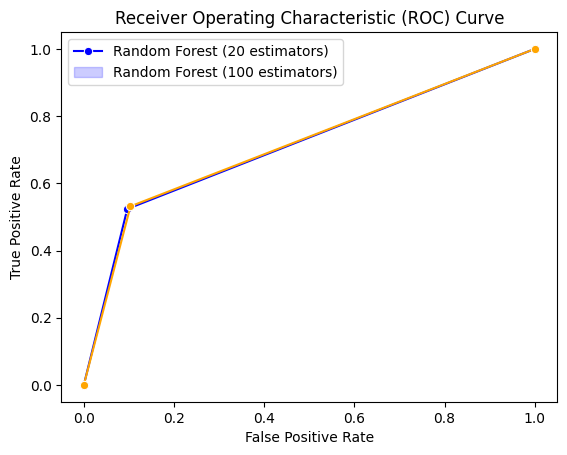

In [ ]:
print('Plotting ROC Curve...')
#returns the predicted class labels based on the majority vote of the individual trees
#For a binary classification problem, it might output 0 or 1, representing the predicted class
plt.figure()
sns.lineplot(x=fpr_20, y=tpr_20, color='blue', marker='o')
sns.lineplot(x=fpr_100, y=tpr_100, color='orange', marker='o')

plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

#legend labels the same but differentiate colors
plt.legend(['Random Forest (20 estimators)', 'Random Forest (100 estimators)'])

plt.show()

In [ ]:

param_grid = {
    'n_estimators': [20, 50, 100],#number of trees
    'max_depth': [10, 20, 30],#depth of each tree
    'min_samples_split': [2, 5, 10],#split internal node
    'min_samples_leaf': [1, 2, 4],#samples in leaf node
    'max_features': ['sqrt', 'log2']#features tree uses when making decision
}

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='f1')
grid_search.fit(X_val, y_val)

# Access best parameters from the best_estimator_ attribute
best_n_estimators = grid_search.best_estimator_.n_estimators
print(best_n_estimators)
best_max_depth = grid_search.best_estimator_.max_depth
print(best_max_depth)
best_min_samples_split = grid_search.best_estimator_.min_samples_split
print(best_min_samples_split)
best_min_samples_leaf = grid_search.best_estimator_.min_samples_leaf
print(best_min_samples_leaf)
best_max_features = grid_search.best_estimator_.max_features
print(best_max_features)

20
30
5
1
sqrt


In [ ]:

param_grid = {
    'n_estimators': [20, 50, 100],#number of trees
    'max_depth': [10, 20, 30],#depth of each tree
    'min_samples_split': [2, 5, 10],#split internal node
    'min_samples_leaf': [1, 2, 4],#samples in leaf node
    'max_features': ['sqrt', 'log2']#features tree uses when making decision
}

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='roc_auc')
grid_search.fit(X_val, y_val)

# Access best parameters from the best_estimator_ attribute
best_n_estimators = grid_search.best_estimator_.n_estimators
print(best_n_estimators)
best_max_depth = grid_search.best_estimator_.max_depth
print(best_max_depth)
best_min_samples_split = grid_search.best_estimator_.min_samples_split
print(best_min_samples_split)
best_min_samples_leaf = grid_search.best_estimator_.min_samples_leaf
print(best_min_samples_leaf)
best_max_features = grid_search.best_estimator_.max_features
print(best_max_features)

100
30
5
2
sqrt


In [ ]:
param_grid = {
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [10, 20, 30],#none?
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
model=RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1')
grid_search.fit(X_val, y_val)
best_n = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
print(best_n)
print(best_max_depth)
print(best_min_samples_split)
print(best_min_samples_leaf)
#more vAriation

20
30
5
1


In [ ]:
param_grid = {
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [10, 20, 30],#none?
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
model=RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_val, y_val)
best_n = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_min_samples_split = grid_search.best_params_['min_samples_split']
best_min_samples_leaf = grid_search.best_params_['min_samples_leaf']
print(best_n)
print(best_max_depth)
print(best_min_samples_split)
print(best_min_samples_leaf)
#more vAriation

150
20
2
2
